# Karim Kuserbaev

## Импорт библиотек и настройки

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install catboost

In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import catboost
from catboost import *
from catboost import datasets

ModuleNotFoundError: No module named 'catboost'

In [3]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

geopandas==0.13.2
lightgbm==4.1.0
numpy==1.25.2
pandas==2.0.3
pandas-datareader==0.10.0
pandas-gbq==0.19.2
pandas-stubs==2.0.3.230814
scikit-learn==1.2.2
sklearn-pandas==2.2.0


In [4]:
pd.options.display.max_rows = 93
pd.options.display.max_columns = 93

## Загрузка данных

In [5]:
train_df = pd.read_parquet("/content/drive/MyDrive/Hakaton/restored_train.pqt")
test_df = pd.read_parquet("/content/drive/MyDrive/Hakaton/restored_test.pqt")

## Анализ

Размерность

In [6]:
train_df.shape, test_df.shape

((600000, 93), (290120, 92))

In [7]:
train_df.head()

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,ogrn_month,ogrn_year,ft_registration_date,max_founderpres,min_founderpres,ogrn_exist_months,okved,segment,sum_of_paym_2m,sum_of_paym_6m,sum_of_paym_1y,sum_a_oper_1m,cnt_a_oper_1m,sum_b_oper_1m,cnt_b_oper_1m,sum_c_oper_1m,cnt_c_oper_1m,sum_deb_d_oper_1m,cnt_deb_d_oper_1m,sum_cred_d_oper_1m,cnt_cred_d_oper_1m,sum_deb_e_oper_1m,cnt_deb_e_oper_1m,cnt_days_deb_e_oper_1m,sum_cred_e_oper_1m,cnt_cred_e_oper_1m,cnt_days_cred_e_oper_1m,sum_deb_f_oper_1m,cnt_deb_f_oper_1m,cnt_days_deb_f_oper_1m,sum_cred_f_oper_1m,cnt_cred_f_oper_1m,cnt_days_cred_f_oper_1m,sum_deb_g_oper_1m,cnt_deb_g_oper_1m,cnt_days_deb_g_oper_1m,sum_cred_g_oper_1m,cnt_cred_g_oper_1m,cnt_days_cred_g_oper_1m,sum_deb_h_oper_1m,cnt_deb_h_oper_1m,cnt_days_deb_h_oper_1m,sum_cred_h_oper_1m,cnt_cred_h_oper_1m,cnt_days_cred_h_oper_1m,sum_a_oper_3m,cnt_a_oper_3m,sum_b_oper_3m,cnt_b_oper_3m,sum_c_oper_3m,cnt_c_oper_3m,sum_deb_d_oper_3m,cnt_deb_d_oper_3m,sum_cred_d_oper_3m,cnt_cred_d_oper_3m,sum_deb_e_oper_3m,cnt_deb_e_oper_3m,cnt_days_deb_e_oper_3m,sum_cred_e_oper_3m,cnt_cred_e_oper_3m,cnt_days_cred_e_oper_3m,sum_deb_f_oper_3m,cnt_deb_f_oper_3m,cnt_days_deb_f_oper_3m,sum_cred_f_oper_3m,cnt_cred_f_oper_3m,cnt_days_cred_f_oper_3m,sum_deb_g_oper_3m,cnt_deb_g_oper_3m,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,ogrn_month_0,ogrn_year_1,2.452182,2.736461,2.932560,2.437979,okved_30,segment_1,0.942275,0.536013,0.511490,-0.188835,0.417022,-0.030225,0.435995,-0.103359,0.550798,-0.128513,0.967030,-0.063678,0.221993,0.396523,0.893064,0.463405,0.505823,0.873795,0.623277,-0.125219,0.771335,0.212528,-0.017983,0.154163,0.777702,-0.041418,0.513943,0.848818,0.099899,0.226247,0.391439,1.054211,0.654057,0.387856,1.171020,0.648942,0.661628,-0.207082,0.208461,-0.029964,0.517298,-0.119654,0.960017,-0.143207,0.870124,-0.084701,0.307935,0.356556,0.426034,1.201541,0.435983,0.864246,1.270517,-0.152107,0.286074,0.891856,-0.025646,0.24851,0.038562,-0.040649,0.458055,0.728507,0.186820,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,ogrn_month_0,ogrn_year_1,2.469917,2.756014,2.952725,2.455375,okved_30,segment_1,0.645704,0.536378,0.486425,-0.188835,0.417022,-0.030225,0.435995,-0.103359,0.550798,-0.088209,0.969891,-0.063678,0.221993,0.131636,0.893042,0.398889,0.095082,0.873685,0.526503,-0.101797,0.771350,0.244786,-0.017983,0.154163,0.777702,-0.041418,0.513943,0.848818,-0.021465,0.224276,0.326923,0.419979,0.652830,0.258824,0.410410,0.633498,0.564854,-0.207082,0.208461,-0.029964,0.517298,-0.119654,0.960017,-0.127755,0.870983,-0.084701,0.307935,0.302226,0.425993,1.135607,0.411205,0.864251,1.237550,-0.142187,0.286081,0.902845,-0.025646,0.24851,0.038562,-0.040649,0.458055,0.728507,0.125043,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,ogrn_month_0,ogrn_year_1,2.485936,2.773674,2.970940,2.472771,okved_30,segment_1,0.403604,0.613167,0.480547,-0.188835,0.417022,-0.030225,0.435995,-0.103359,0.550798,-0.128513,0.967030,-0.063678,0.221993,0.485924,0.893049,0.560179,0.148894,0.873656,0.623277,-0.125219,0.771335,0.212528,-0.017983,0.154163,0.777702,-0.041418,0.513943,0.848818,-0.029795,0.223291,0.294665,1.251369,0.653444,0.387856,0.552757,0.629637,0.661628,-0.207082,0.208461,-0.029964,0.517298,-0.119654,0.960017,-0.127755,0.870983,-0.084701

Проверка на дубликаты

In [ ]:
train_df.duplicated(keep='first').sum()

0

Проверка на пропуски

In [ ]:
train_df.isna().sum()

id                              0
date                            0
balance_amt_avg             65577
balance_amt_max             65577
balance_amt_min             65577
balance_amt_day_avg         65577
channel_code                    0
city                            0
city_type                       0
index_city_code                 0
ogrn_days_end_month         31473
ogrn_days_end_quarter       31473
ogrn_month                      0
ogrn_year                       0
ft_registration_date        31360
max_founderpres            335592
min_founderpres            335592
ogrn_exist_months           31473
okved                           0
segment                         0
sum_of_paym_2m             148884
sum_of_paym_6m             148884
sum_of_paym_1y             148884
sum_a_oper_1m                   0
cnt_a_oper_1m              196181
sum_b_oper_1m                   0
cnt_b_oper_1m              196181
sum_c_oper_1m                   0
cnt_c_oper_1m              196181
sum_deb_d_oper

In [ ]:
test_df.isna().sum()

id                              0
date                            0
balance_amt_avg             29483
balance_amt_max             29483
balance_amt_min             29483
balance_amt_day_avg         29483
channel_code                    0
city                            0
city_type                       0
index_city_code                 0
ogrn_days_end_month         14278
ogrn_days_end_quarter       14278
ogrn_month                      0
ogrn_year                       0
ft_registration_date        14838
max_founderpres            161192
min_founderpres            161192
ogrn_exist_months           14278
okved                           0
segment                         0
sum_of_paym_2m              73461
sum_of_paym_6m              73461
sum_of_paym_1y              73461
sum_a_oper_1m                   0
cnt_a_oper_1m               95210
sum_b_oper_1m                   0
cnt_b_oper_1m               95210
sum_c_oper_1m                   0
cnt_c_oper_1m               95210
sum_deb_d_oper

Количество дубликатов

In [ ]:
train_df.dropna().shape

(173529, 93)

In [ ]:
test_df.dropna().shape

(82665, 92)

Информация

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 93 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       600000 non-null  int64  
 1   date                     600000 non-null  object 
 2   balance_amt_avg          534423 non-null  float64
 3   balance_amt_max          534423 non-null  float64
 4   balance_amt_min          534423 non-null  float64
 5   balance_amt_day_avg      534423 non-null  float64
 6   channel_code             600000 non-null  object 
 7   city                     600000 non-null  object 
 8   city_type                600000 non-null  object 
 9   index_city_code          600000 non-null  object 
 10  ogrn_days_end_month      568527 non-null  float64
 11  ogrn_days_end_quarter    568527 non-null  float64
 12  ogrn_month               600000 non-null  object 
 13  ogrn_year                600000 non-null  object 
 14  ft_r

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290120 entries, 0 to 290119
Data columns (total 92 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       290120 non-null  int64  
 1   date                     290120 non-null  object 
 2   balance_amt_avg          260637 non-null  float64
 3   balance_amt_max          260637 non-null  float64
 4   balance_amt_min          260637 non-null  float64
 5   balance_amt_day_avg      260637 non-null  float64
 6   channel_code             290120 non-null  object 
 7   city                     290120 non-null  object 
 8   city_type                290120 non-null  object 
 9   index_city_code          290120 non-null  object 
 10  ogrn_days_end_month      275842 non-null  float64
 11  ogrn_days_end_quarter    275842 non-null  float64
 12  ogrn_month               290120 non-null  object 
 13  ogrn_year                290120 non-null  object 
 14  ft_r

Начальные кластеры

In [ ]:
test_df['start_cluster'].value_counts()

start_cluster
{α}          170103
{}            51842
{α, η}        19619
{other}       15694
{α, γ}        15209
{α, β}         5346
{α, δ}         4224
{α, ε}         2463
{α, θ}         2049
{α, ψ}         1307
{α, μ}          735
{α, ε, η}       612
{α, λ}          365
{α, ε, θ}       345
{α, ε, ψ}       126
{λ}              72
{α, π}            9
Name: count, dtype: int64

In [ ]:
train_df[['id', 'date', 'start_cluster', 'end_cluster']].isna().sum()

id               0
date             0
start_cluster    0
end_cluster      0
dtype: int64

## Предобработка

In [ ]:
list_of_col_train = train_df.columns[train_df.isna().sum() > 0].tolist()
list_of_col_test = test_df.columns[test_df.isna().sum() > 0].tolist()
list_of_col_train_cat = [
    "channel_code", "city", "city_type",
    "okved", "segment",
    "index_city_code", "ogrn_month", "ogrn_year",
    'start_cluster'
]
list_of_custom_cols = ["balance_amt_avg",
"balance_amt_max",
"balance_amt_min",
"balance_amt_day_avg",
"channel_code",
"city",
"city_type",
"index_city_code",
"ogrn_days_end_month",
"ogrn_days_end_quarter",
"ogrn_month",
"ogrn_year",
"ft_registration_date",
"max_founderpres",
"min_founderpres",
"ogrn_exist_months",
"okved",
"segment",
"sum_of_paym_2m",
"sum_of_paym_6m",
"sum_of_paym_1y"]

list_of_custom_cols_test = ["balance_amt_avg",
"balance_amt_max",
"balance_amt_min",
"balance_amt_day_avg",
"channel_code",
"city",
"city_type",
"index_city_code",
"ogrn_days_end_month",
"ogrn_days_end_quarter",
"ogrn_month",
"ogrn_year",
"ft_registration_date",
"max_founderpres",
"min_founderpres",
"ogrn_exist_months",
"okved",
"segment",
"sum_of_paym_2m",
"sum_of_paym_6m",
"sum_of_paym_1y",
'start_cluster']

In [ ]:
def restore_data(df, list_of_col):
    # Копия датасета чтобы не грязнить основной
    restored_df = df.copy()

    # Цикл по всем необходимым столбцам
    # Некоторые столбцы не имеют пропусков, поэтому их даже не трогаю
    # Можно задавать кастомные столбцы, чтоб например обработать только 5 столбцов
    for name_of_col in list_of_col:
      # Вывод информации чтоб понимать на каком мы этапе
      print('Столбец', name_of_col)

      # РАБОТАЕТ ПИЗДЕЦ КАК МЕДЛЕННО, У МЕНЯ БАБУШКА ХОДИТ БЫСТРЕЕ В МАГАЗ
      # Вариант 1 - числовые значения
      if restored_df[name_of_col].dtype in [np.float16, np.int64, np.float64, np.int32, np.int16, np.float32]: # проверка на числовые значения (какой тип данных в столбце)

          # temp_df - сабсет с id, date и name_pf_col, с удаленными пропусками
          temp_df = restored_df[['id','date', name_of_col]].copy().dropna()

          # маска, чтобы оставить в temp_df только те id,
          # которые встречаются 2-3 раза
          # это нужно чтобы считать изменение значения по name_of_col (10 -> 15 = прирост 1.5)
          # с единственным значением не посчитаешь так
          mask = temp_df['id'].value_counts().isin([2, 3])
          temp_df = temp_df[temp_df['id'].isin(mask.index[mask])]

          # Разделение данных по id
          # Как раз для подсчета изменения в каждом случае
          grouped_data = temp_df.groupby('id')
          growth_rates = []

          # Вычисление среднего коэффициента изменения для каждого id
          for id_val, group in grouped_data:
              if len(group) == 3:  # Убедиться, что у нас есть данные для расчета прироста
                  # Вычислить изменения между соседними месяцами
                  growth_rate = ((group[name_of_col].iloc[2] / group[name_of_col].iloc[1]) +
                                (group[name_of_col].iloc[1] / group[name_of_col].iloc[0])) / 2
                  growth_rates.append(growth_rate)

                  # Это когда всего 2 значения
              elif len(group) == 2:
                  growth_rate = group[name_of_col].iloc[1] / group[name_of_col].iloc[0]
                  growth_rates.append(growth_rate)

          # Найти среднее значение средних коэффициентов изменения
          # growth_rates = np.abs(growth_rates) # это не надо, не логично, потому что не учитывает убыль, а только прибыль, короче хуйня не используем

          # среднее изменение столбца (в формате 0.05, что означает в среднем по столбцу разница от месяца к месяцу прирост 5%)
          aver_diff = np.mean(growth_rates)-1


          # Цикл по каждому клиенту (id)
          for id_val in restored_df['id'].unique():

            # Информация для вывода (понимать на каком мы этапе)
            if id_val % 10000 == 0:
              print('Index', id_val)

            # available_months - сабсет из 1-3 значений (зависит от пропусков)
            # в нем 1-3 значения конкретного id, также date и значение name_of_col
            # также пропуски убираются
            available_months = restored_df[restored_df['id'] == id_val].copy()[['date', name_of_col]].dropna(axis=0)

            # Проверка, сколько доступно значений name_of_col (короче сколько не пропущено)
            # если всего 1 значение, значит 2 пропуска нужно восстановить
            if len(available_months[name_of_col].values) == 1:

                # Если у нас доступно только одно значение и оно в month_1
                # Тогда мы берем это значение (first_value)
                # и домножаем по среднему изменению и получаем month_2 и month_3
                if ['month_1'] in available_months['date'].values:
                    first_value = available_months.loc[available_months['date'] == 'month_1', name_of_col].values[0]
                    restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_2'), name_of_col] = first_value * (1+aver_diff)
                    restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_3'), name_of_col] = first_value * (1+aver_diff) * (1+aver_diff)

                # Если у нас доступно только одно значение и оно в month_2
                # Тогда мы берем это значение (first_value)
                # и домножаем по среднему изменению и получаем month_1 и month_3
                elif ['month_2'] in available_months['date'].values:
                    first_value = available_months.loc[available_months['date'] == 'month_2',name_of_col].values[0]
                    restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_1'), name_of_col] = first_value / (1 + aver_diff)
                    restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_3'), name_of_col] = first_value * (1 + aver_diff)

                # Если у нас доступно только одно значение и оно в month_3
                # Тогда мы берем это значение (first_value)
                # и домножаем по среднему изменению и получаем month_1 и month_2
                elif ['month_3'] in available_months['date'].values:
                    first_value = available_months.loc[available_months['date'] == 'month_3', name_of_col].values[0]
                    restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_1'), name_of_col] = first_value / (1 + aver_diff) / (1 + aver_diff)
                    restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_2'), name_of_col] = first_value / (1 + aver_diff)

            # Если доступно изначально 2 значения (1 пропуск заполнить)
            elif len(available_months[name_of_col].values) == 2:

                # Если есть month_1 и month_2, надо найти month_3
                if ('month_1' in available_months['date'].values) and ('month_2' in available_months['date'].values):
                  first_value = available_months.loc[available_months['date'] == 'month_1', name_of_col].values[0]
                  second_value = available_months.loc[available_months['date'] == 'month_2', name_of_col].values[0]
                  restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_3'), name_of_col] = second_value * (second_value/first_value)

                # Если есть month_1 и month_3, надо найти month_2
                elif ('month_1' in available_months['date'].values) and ('month_3' in available_months['date'].values):
                  first_value = available_months.loc[available_months['date'] == 'month_1', name_of_col].values[0]
                  second_value = available_months.loc[available_months['date'] == 'month_3', name_of_col].values[0]
                  restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_2'), name_of_col] = (first_value + second_value)/2

                # Если есть month_2 и month_3, надо найти month_1
                elif ('month_2' in available_months['date'].values) and ('month_3' in available_months['date'].values):
                  first_value = available_months.loc[available_months['date'] == 'month_2', name_of_col].values[0]
                  second_value = available_months.loc[available_months['date'] == 'month_3', name_of_col].values[0]
                  restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_1'), name_of_col] = first_value * (first_value/second_value)

            # Если вообще нету значений ни по какому из месяцев
            elif len(available_months[name_of_col].values) == 0:
                  mean_of_col = temp_df[name_of_col].mean() # берем среднее по стобцу значение
                  var_of_col = temp_df[name_of_col].var() # находим дисперсию
                  first_value = mean_of_col + np.random.uniform(-var_of_col, var_of_col) # получаем среднее значение с рандомным значением в дисперсии
                  # насчет np.random.uniform(-var_of_col, var_of_col) не уверен, берет он одно значение или как...
                  restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_1'), name_of_col] = first_value
                  restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_2'), name_of_col] = first_value * (1 + aver_diff)
                  restored_df.loc[(restored_df['id'] == id_val) & (restored_df['date'] == 'month_3'), name_of_col] = first_value * (1 + aver_diff) * (1+aver_diff)


      else:
        # РАБОТАЕТ, ТУТ ВСЕ ОКЕЙ, НО ЕСЛИ ЕСТЬ ИДЕИ - ДОБАВЛЯЙТЕ
        # Вариант 2 - категориальные значения
          value_counts = restored_df[name_of_col].value_counts(normalize=True) # получаем список возможных значений конкретного столбца и их вероятность появления от 0 до 1
          for id_val in restored_df['id'].unique(): # цикл по всем id (клиентам), которые есть

              # информация для вывода, чтобы понять, на каком мы этапе обработки
              if id_val % 10000 == 0:
                  print('Index', id_val)

              # id_data - сабсет с айди клиента, месяцами и нужным столбцом, который мы обрабатываем
              # также пропуски убираю, дальше увидите почему
              id_data = restored_df[restored_df['id'] == id_val][['id', 'date', name_of_col]].dropna()
              len_id_data = len(id_data)

              # если пропусков нету, значит все значения конкретного столбца name_of_col заполнены
              # а значит пропускаем
              if len_id_data == 3:
                  continue

              # если есть 1 или 2 пропуска, то беру доступное значение с другого месяца и заполняю им пропуски
              elif len_id_data > 0:
                value1 = id_data[name_of_col].values[0]
                restored_df.loc[(restored_df['id'] == id_val), name_of_col] = value1

              # если вообще нет информации о типе, тогда берем value_counts, описанный выше, и рандомно выбираем
              # значение по распределению столбца
              elif len_id_data == 0:
                value2 = np.random.choice(value_counts.index, p=value_counts.values)
                restored_df.loc[(restored_df['id'] == id_val), name_of_col] = value2



    return restored_df

# Usage
# restored_df_train = restore_data(train_df, list_of_custom_cols)
# restored_df_train.to_parquet('restored_train_clear.pqt')

test_df = restore_data(test_df, ['start_cluster'])
# restored_df_train.to_parquet('restored_test.pqt')

Столбец start_cluster
Index 200000
Index 210000
Index 220000
Index 230000
Index 240000
Index 250000
Index 260000
Index 270000
Index 280000
Index 290000


In [ ]:
train_df.drop(['cnt_a_oper_3m', 'cnt_deb_f_oper_3m', 'cnt_days_deb_f_oper_3m', 'cnt_deb_h_oper_3m', 'cnt_days_cred_h_oper_3m', 'sum_cred_e_oper_3m', 'cnt_cred_d_oper_3m', 'sum_deb_f_oper_3m', 'max_founderpres', 'sum_c_oper_3m', 'sum_cred_e_oper_1m', 'sum_deb_g_oper_3m', 'cnt_cred_h_oper_3m', 'balance_amt_day_avg', 'cnt_days_cred_f_oper_3m', 'cnt_days_cred_e_oper_3m', 'sum_deb_d_oper_3m', 'sum_of_paym_6m', 'balance_amt_max', 'cnt_cred_g_oper_3m', 'sum_deb_e_oper_1m', 'cnt_c_oper_3m', 'sum_cred_f_oper_3m', 'ogrn_exist_months', 'cnt_days_deb_h_oper_3m', 'cnt_days_deb_e_oper_3m', 'sum_a_oper_3m', 'cnt_days_deb_g_oper_3m', 'cnt_deb_e_oper_3m', 'cnt_cred_e_oper_3m', 'cnt_deb_f_oper_1m', 'sum_cred_h_oper_3m', 'sum_cred_g_oper_3m', 'sum_cred_d_oper_3m', 'cnt_cred_e_oper_1m', 'sum_b_oper_3m', 'sum_deb_h_oper_1m', 'cnt_cred_f_oper_3m', 'cnt_days_cred_g_oper_3m', 'sum_cred_g_oper_1m', 'cnt_deb_g_oper_3m', 'cnt_deb_d_oper_3m'], axis=1, inplace=True)
train_df.dropna(inplace=True, axis=0)

In [ ]:
cat_names = [
    "channel_code", "city", "city_type",
    "index_city_code", "ogrn_month", "ogrn_year",
    "okved", "segment", "start_cluster"
]

In [ ]:
cat_features = [6, 7, 8, 9, 12, 13, 18, 19, 91]

In [ ]:
from catboost.utils import create_cd

feature_names = dict()

for i in range(len(cat_features)):
    feature_names[cat_features[i]] = cat_names[i]


create_cd(
    label=0,
    cat_features=cat_features,
    feature_names=feature_names,
    output_path=os.path.join('', 'train.cd')
)

In [ ]:
!cat /kaggle/working/train.cd

0	Label	
6	Categ	channel_code
7	Categ	city
8	Categ	city_type
9	Categ	index_city_code
12	Categ	ogrn_month
13	Categ	ogrn_year
18	Categ	okved
19	Categ	segment
91	Categ	start_cluster


Дизбаланс классов

In [8]:
train_df['end_cluster'].value_counts()

end_cluster
{α}          318670
{}           122366
{other}       47197
{α, η}        40810
{α, γ}        34471
{α, β}        11203
{α, θ}         6511
{α, ε}         5450
{α, δ}         4078
{α, ψ}         2929
{α, μ}         2123
{α, ε, η}      1674
{α, ε, θ}      1125
{α, λ}          873
{α, ε, ψ}       361
{λ}             140
{α, π}           19
Name: count, dtype: int64

In [12]:
train_df['end_cluster'].value_counts(normalize=True)

end_cluster
{α}          0.531117
{}           0.203943
{other}      0.078662
{α, η}       0.068017
{α, γ}       0.057452
{α, β}       0.018672
{α, θ}       0.010852
{α, ε}       0.009083
{α, δ}       0.006797
{α, ψ}       0.004882
{α, μ}       0.003538
{α, ε, η}    0.002790
{α, ε, θ}    0.001875
{α, λ}       0.001455
{α, ε, ψ}    0.000602
{λ}          0.000233
{α, π}       0.000032
Name: proportion, dtype: float64

In [ ]:
# Calculate current class proportions
class_proportions = train_df['end_cluster'].value_counts(normalize=True)

# Identify underrepresented classes
underrepresented_classes = class_proportions[class_proportions < 0.05].index

# Create an empty list to store additional rows
additional_rows = []

# Calculate the number of additional rows needed for each underrepresented class
for class_label in underrepresented_classes:
    current_proportion = class_proportions[class_label]
    desired_proportion = 0.05
    current_count = (train_df['end_cluster'] == class_label).sum()
    desired_count = int(desired_proportion * len(train_df))
    additional_count = desired_count - current_count

    # Sample additional rows from the original dataset
    additional_samples = train_df[train_df['end_cluster'] == class_label].sample(n=additional_count, replace=True)
    additional_rows.append(additional_samples)

# Concatenate additional rows with the original dataframe
if additional_rows:
    train_df = pd.concat([train_df] + additional_rows, ignore_index=True)

# Verify the class proportions after balancing
print(train_df['end_cluster'].value_counts(normalize=True))


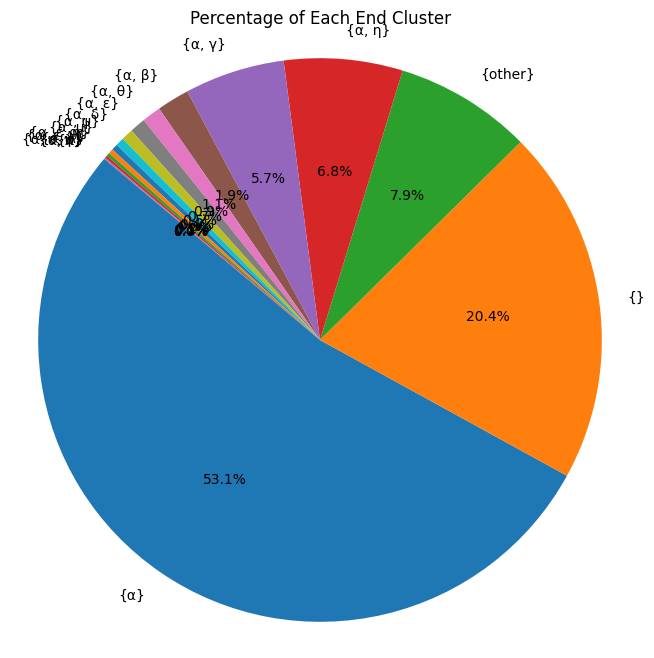

In [10]:
import matplotlib.pyplot as plt

# Calculate value counts of 'end_cluster' column
cluster_counts = train_df['end_cluster'].value_counts(normalize=True)

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each End Cluster')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


Обозначение категориальных признаков

In [ ]:
train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

In [ ]:
label_encoders = {}

for col in cat_names:
    label_encoders[col] = LabelEncoder().fit(train_df[col])
    train_df[col] = label_encoders[col].transform(train_df[col])
    test_df[col] = label_encoders[col].transform(test_df[col])

Создаем выборки для валидации и обучения

In [ ]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [ ]:
cat_features_x = [4, 5, 6, 7, 10, 11, 16, 17, 89]

In [ ]:
pool1 = Pool(data=X, label=y, cat_features=cat_features_x)



print("Dataset shape")
print(f"Dataset 1: {str(pool1.shape)}")

print()
print("Column names")
print(f"Dataset 1: {pool1.get_feature_names()}")


Dataset shape
Dataset 1: (600000, 90)

Column names
Dataset 1: ['balance_amt_avg', 'balance_amt_max', 'balance_amt_min', 'balance_amt_day_avg', 'channel_code', 'city', 'city_type', 'index_city_code', 'ogrn_days_end_month', 'ogrn_days_end_quarter', 'ogrn_month', 'ogrn_year', 'ft_registration_date', 'max_founderpres', 'min_founderpres', 'ogrn_exist_months', 'okved', 'segment', 'sum_of_paym_2m', 'sum_of_paym_6m', 'sum_of_paym_1y', 'sum_a_oper_1m', 'cnt_a_oper_1m', 'sum_b_oper_1m', 'cnt_b_oper_1m', 'sum_c_oper_1m', 'cnt_c_oper_1m', 'sum_deb_d_oper_1m', 'cnt_deb_d_oper_1m', 'sum_cred_d_oper_1m', 'cnt_cred_d_oper_1m', 'sum_deb_e_oper_1m', 'cnt_deb_e_oper_1m', 'cnt_days_deb_e_oper_1m', 'sum_cred_e_oper_1m', 'cnt_cred_e_oper_1m', 'cnt_days_cred_e_oper_1m', 'sum_deb_f_oper_1m', 'cnt_deb_f_oper_1m', 'cnt_days_deb_f_oper_1m', 'sum_cred_f_oper_1m', 'cnt_cred_f_oper_1m', 'cnt_days_cred_f_oper_1m', 'sum_deb_g_oper_1m', 'cnt_deb_g_oper_1m', 'cnt_days_deb_g_oper_1m', 'sum_cred_g_oper_1m', 'cnt_cred_g_

In [ ]:
from catboost import cv

params = {
    'loss_function': 'MultiClass',
    'iterations': 512,
    'random_seed': 43,
    'learning_rate': 0.1,
    'depth': 12,
    'task_type': 'GPU',
    'devices':'0'
}

cv_data = cv(
    params=params,
    pool=pool1,
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=0,
    plot=True, # Никуда без визуализатора
    stratified=True,
    verbose=30
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 2.0352451	test: 2.0356980	best: 2.0356980 (0)	total: 512ms	remaining: 4m 21s
30:	learn: 0.8554373	test: 0.8712773	best: 0.8712773 (30)	total: 16.9s	remaining: 4m 22s
60:	learn: 0.7947522	test: 0.8246866	best: 0.8246866 (60)	total: 33.6s	remaining: 4m 8s
90:	learn: 0.7590677	test: 0.8060944	best: 0.8060944 (90)	total: 50.8s	remaining: 3m 54s
120:	learn: 0.7298197	test: 0.7923313	best: 0.7923313 (120)	total: 1m 7s	remaining: 3m 38s
150:	learn: 0.7000708	test: 0.7792932	best: 0.7792932 (150)	total: 1m 25s	remaining: 3m 23s
180:	learn: 0.6718622	test: 0.7670292	best: 0.7670292 (180)	total: 1m 42s	remaining: 3m 7s
210:	learn: 0.6465212	test: 0.7560305	best: 0.7560305 (210)	total: 1m 59s	remaining: 2m 50s
240:	learn: 0.6208759	test: 0.7454373	best: 0.7454373 (240)	total: 2m 17s	remaining: 2m 34s
270:	learn: 0.6002261	test: 0.7368691	best: 0.7368691 (270)	total: 2m 34s	remaining: 2m 17s
300:	learn: 0.5793612	test: 0.7275141	best: 0.7275141 (300)	total: 2m 51s	

KeyboardInterrupt: 

In [ ]:
cv_data

In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print("Best validation Logloss score, stratified: {:.4f}+/-{:.3f} on step {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

## Обучение модели

### CatBoostClassifier

model #7

In [ ]:
model = CatBoostClassifier(iterations=1024,
                           depth=13,
                           learning_rate=0.075,
                           random_seed=43,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                          )

In [ ]:
model.fit(
    x_train, y_train,
    cat_features=np.array(cat_names),
    eval_set=(x_val, y_val),
    verbose=15,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2217977	test: 2.2234760	best: 2.2234760 (0)	total: 1s	remaining: 17m 4s
15:	learn: 1.0702212	test: 1.0780700	best: 1.0780700 (15)	total: 15.8s	remaining: 16m 35s
30:	learn: 0.8955309	test: 0.9115671	best: 0.9115671 (30)	total: 31.3s	remaining: 16m 43s
45:	learn: 0.8349999	test: 0.8605016	best: 0.8605016 (45)	total: 47.4s	remaining: 16m 46s
60:	learn: 0.8058072	test: 0.8375057	best: 0.8375057 (60)	total: 1m 2s	remaining: 16m 33s
75:	learn: 0.7814049	test: 0.8230622	best: 0.8230622 (75)	total: 1m 19s	remaining: 16m 29s
90:	learn: 0.7644671	test: 0.8140569	best: 0.8140569 (90)	total: 1m 35s	remaining: 16m 19s
105:	learn: 0.7480482	test: 0.8060426	best: 0.8060426 (105)	total: 1m 51s	remaining: 16m 4s
120:	learn: 0.7330863	test: 0.7986402	best: 0.7986402 (120)	total: 2m 7s	remaining: 15m 49s
135:	learn: 0.7167579	test: 0.7912322	best: 0.7912322 (135)	total: 2m 23s	remaining: 15m 37s
150:	learn: 0.6990956	test: 0.7835782	best: 0.7835782 (150)	total: 2m 40s	remaining: 15m 25s
165:

In [ ]:
model.save_model('catboost_model_7.json')

In [ ]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,okved,12.414585
1,index_city_code,9.425389
2,channel_code,9.326252
3,ogrn_month,7.184533
4,ogrn_days_end_month,6.400968
5,start_cluster,6.323104
6,ogrn_days_end_quarter,6.220017
7,city,5.528557
8,segment,3.373929
9,ogrn_year,3.330319


### LGBM

В качестве базовой модели возьмем LGBM обучим на всех признаках

In [ ]:
model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

### Метрики

Зададим функцию для взвешенной метрики roc auc

In [ ]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [ ]:
cluster_weights = pd.read_excel("/kaggle/input/alfa-hack-dataset/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [ ]:
y_pred_proba = model.predict_proba(x_val)
y_pred_proba.shape

(120000, 17)

In [ ]:
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.9696687374457332

## Прогноз на тестовой выборке

In [ ]:
test_df.pivot(index="id", columns="date", values="start_cluster").head(3)

date,month_4,month_5,month_6
id,,,
200000,15.0,15.0,15.0
200001,15.0,15.0,15.0
200002,0.0,0.0,0.0


Для того, чтобы сделать прогноз на тестовой выборке, нужно заполнить стартовый кластер. </br>
В качестве базового подхода заполним все стартовые кластеры, самым популярным кластером.

In [ ]:
test_df['start_cluster'].value_counts()

start_cluster
15    170103
1      51842
9      19619
0      15694
3      15209
2       5346
4       4224
8       2463
10      2049
14      1307
12       735
5        612
11       365
6        345
7        126
16        72
13         9
Name: count, dtype: int64

In [ ]:
test_df["start_cluster"] = train_df["start_cluster"].mode()[0]
# test_df["start_cluster"] = test_df["start_cluster"].astype("category")

In [ ]:
sample_submission_df = pd.read_csv("/kaggle/input/sample-submission/sample_submission.csv")

In [ ]:
sample_submission_df.shape

(100000, 18)

In [ ]:
sample_submission_df.head()

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
1,200001,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2,200002,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
3,200003,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
4,200004,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


Для тестовой выборки будем использовать только последний месяц

In [ ]:
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)

In [ ]:
cat_features_test = [4, 5, 6, 7, 10, 11, 16, 17, 89]

In [ ]:
pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

In [ ]:
test_pred_proba = model.predict_proba(last_m_test_df) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

In [ ]:
test_pred_proba_df.shape

(100000, 17)

In [ ]:
test_pred_proba_df.head(2)

,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,0.002113,0.005858,0.011363,0.012802,0.002135,0.000034,0.000065,4.380761e-05,0.004219,0.003299,0.003726,0.000108,0.000329,1.442717e-05,0.000606,0.953270,0.000016
1,0.001005,0.473920,0.000081,0.000334,0.000061,0.000014,0.000011,7.364428e-07,0.000076,0.003938,0.000025,0.000012,0.000073,2.200663e-07,0.000019,0.520429,0.000002


In [ ]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_submission_7.csv", index=False)

In [ ]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.002113,0.005858,0.011363,0.012802,0.002135,0.000034,0.000065,4.380761e-05,0.004219,0.003299,0.003726,0.000108,0.000329,1.442717e-05,0.000606,0.953270,1.568262e-05
1,200001,0.001005,0.473920,0.000081,0.000334,0.000061,0.000014,0.000011,7.364428e-07,0.000076,0.003938,0.000025,0.000012,0.000073,2.200663e-07,0.000019,0.520429,2.182816e-06
2,200002,0.754202,0.000572,0.000875,0.113610,0.002303,0.000637,0.000414,4.228547e-04,0.062324,0.003964,0.002523,0.000624,0.000264,3.027303e-05,0.008214,0.048975,4.477714e-05
3,200003,0.013289,0.614117,0.000110,0.000168,0.000063,0.000120,0.000010,3.700854e-06,0.000078,0.022847,0.000555,0.000005,0.000104,6.071929e-07,0.000019,0.348509,7.574914e-07
4,200004,0.184970,0.112109,0.009844,0.043541,0.000868,0.001207,0.000535,6.782468e-05,0.003513,0.181516,0.005141,0.000098,0.004253,2.173743e-05,0.000870,0.451399,4.663891e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.007390,0.201525,0.000602,0.000949,0.000314,0.000004,0.000266,1.094715e-06,0.000976,0.000049,0.000164,0.000069,0.000022,3.889440e-06,0.000035,0.787620,9.697313e-06
99996,299996,0.035382,0.028899,0.006962,0.066568,0.003230,0.000008,0.000051,2.671587e-05,0.002364,0.001491,0.004374,0.002854,0.000353,2.708185e-06,0.000525,0.846883,2.621933e-05
99997,299997,0.030457,0.060531,0.006176,0.024441,0.001240,0.000438,0.000118,2.122848e-05,0.006115,0.000579,0.001066,0.000032,0.000125,3.280689e-06,0.007324,0.861329,4.945855e-06
99998,299998,0.032706,0.162959,0.002091,0.024371,0.000502,0.000045,0.000097,4.593626e-05,0.003704,0.008968,0.002619,0.000277,0.000373,1.968168e-05,0.004693,0.756467,6.225682e-05


In [3]:
import pytorch_tabular